In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Load the dataset to examine its contents
file_path = './archive/2023_GradesVsPeriodAttendance_01.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,school_name,student_id,grade,term_code,bellPeriod1_absences,bellPeriod2_absences,bellPeriod3_absences,bellPeriod4_absences,bellPeriod5_absences,bellPeriod6_absences,total_absences,bellPeriod1_markbook_mark,bellPeriod2_markbook_mark,bellPeriod3_markbook_mark,bellPeriod4_markbook_mark,bellPeriod5_markbook_mark,bellPeriod6_markbook_mark
0,West High School,DF2PJ1C35,9,Semester 1 Final,20,16,18,15,17,17,103,D,C,A,C,C,C
1,West High School,8MED60MM6,9,Semester 1 Final,50,11,10,12,10,15,108,B,C,A,C,A,A
2,West High School,ZCB232N6Q,9,Semester 1 Final,10,4,4,6,10,8,42,A,B,B,B,A,B
3,West High School,989OKS8ZG,9,Semester 1 Final,8,4,4,2,3,4,25,A,A,A,A,A,A
4,West High School,J6EM8W29X,9,Semester 1 Final,19,4,7,5,3,3,41,A,D,B,B,C,B


1. Eroavatko poissaolomäärät eri koulujen välillä?

- Koulujen välillä on selkeitä eroja poissaolomäärissä. Esimerkiksi Small High School
on huomattavasti vähemmän poissaoloja verrattuna muihin kouluihin, kuten East High School tai South High School, joissa poissaolot ovat paljon suurempia.


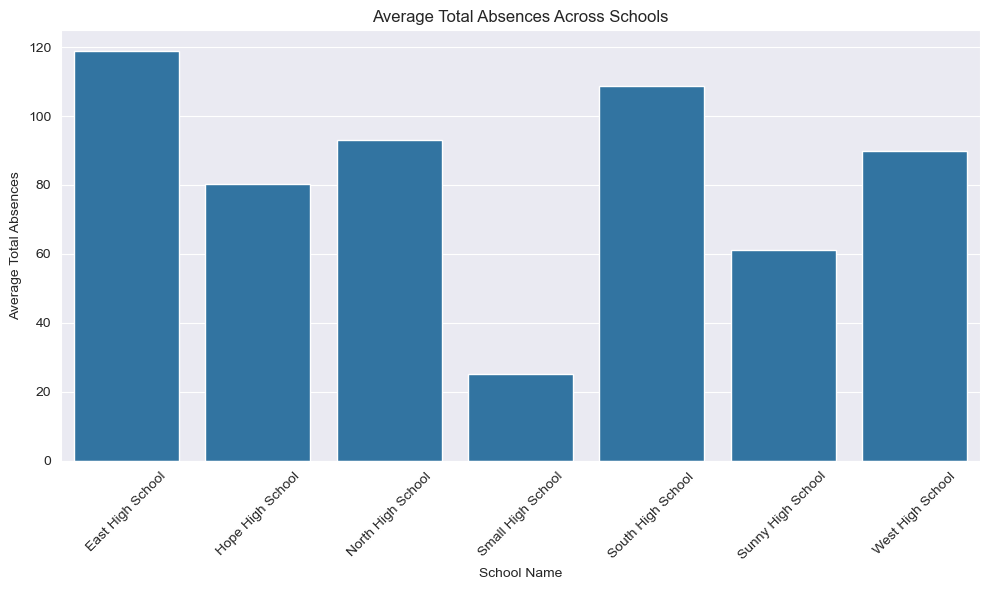

In [11]:
# Group by school to get the average absences
school_performance = data.groupby('school_name').agg(
    avg_total_absences=('total_absences', 'mean')
).reset_index()

# Plot the relationship between schools and average absences
plt.figure(figsize=(10, 6))
sns.barplot(x='school_name', y='avg_total_absences', data=school_performance)
plt.title('Average Total Absences Across Schools')
plt.xlabel('School Name')
plt.ylabel('Average Total Absences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2. Onko joillakin oppitunneilla (esim. ensimmäinen tai kuudes tunti) enemmän poissaoloja kuin muilla?

- Havaitsimme selviä eroja poissaolomäärissä eri jaksojen ja luokka-asteiden välillä.
Ensimmäinen oppitunti on kaikilla luokka-asteilla poissaoloille alttiimpi verrattuna muihin tunteihin. Mitä vanhempiin opiskelijoihin mennään, sitä enemmän poissaoloja kertyy aamun ensimmäisille tunneille. Kuudennen tunnin poissaolot puolestaan laskevat erityisesti vanhempien opiskelijoiden kohdalla, mikä viittaa mahdollisiin aikataulullisiin muutoksiin tai opiskelijoiden sitoutumiseen loppupäivän tunneilla.

- Tämä tieto voi auttaa kouluja kohdentamaan toimenpiteitä juuri aamun ensimmäisiin tunteihin, jotta poissaoloja voitaisiin vähentää erityisesti ylemmillä luokka-asteilla.

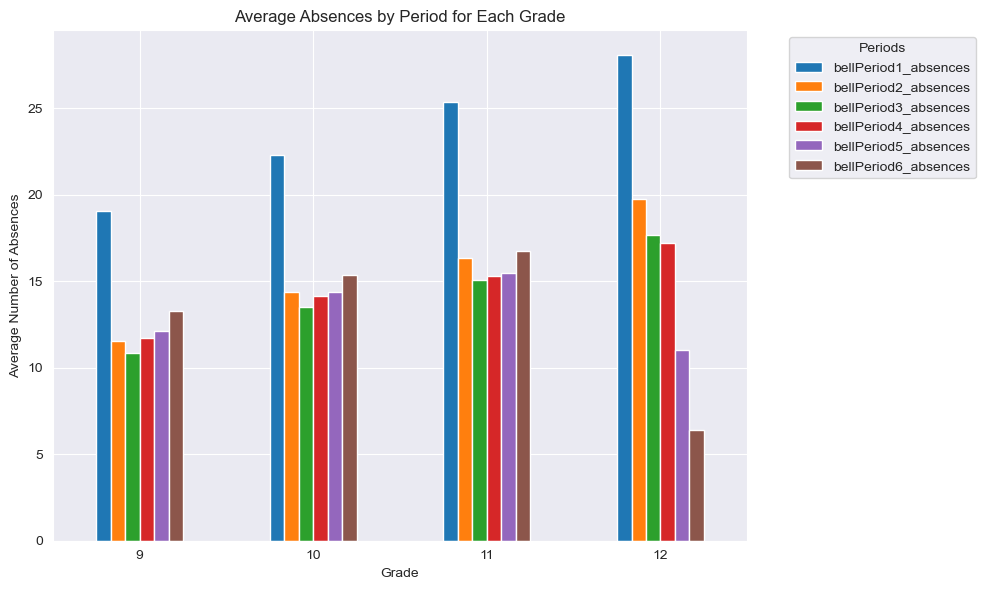

In [12]:
# Calculate average absences for each period, grouped by grade
average_absences_by_grade = data.groupby('grade')[
    ['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
     'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences']
].mean()
 
# Display the average absences per period for each grade
average_absences_by_grade

# Set up the plot
average_absences_by_grade.plot(kind='bar', figsize=(10,6))
plt.title('Average Absences by Period for Each Grade')
plt.ylabel('Average Number of Absences')
plt.xlabel('Grade')
plt.xticks(rotation=0)
plt.legend(title='Periods', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

3. Onko tietyn vuoden opiskelijoilla (esim. 9., 10., 11. tai 12. luokka) korkeampi poissaolojen määrä tai heikommat arvosanat?

- Tulosten perusteella ylemmillä luokka-asteilla (11 ja 12) oppilaat ovat keskimäärin poissa useammin, mutta heidän arvosanansa ovat hieman parempia verrattuna alempiin luokka-asteisiin. 

In [13]:
# Ensure total_absences is an integer type
data['total_absences'] = data['total_absences'].astype(int)

# Define a mapping for letter grades to numerical equivalents
grade_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}

# Replace the letter grades with numerical equivalents for all bell periods
for period in range(1, 7):
    column_name = f'bellPeriod{period}_markbook_mark'
    data[column_name] = data[column_name].map(grade_mapping)

# Calculate the mean of absences and marks per grade level
grouped_data = data.groupby('grade').agg({
    'total_absences': 'mean',
    'bellPeriod1_markbook_mark': 'mean',
    'bellPeriod2_markbook_mark': 'mean',
    'bellPeriod3_markbook_mark': 'mean',
    'bellPeriod4_markbook_mark': 'mean',
    'bellPeriod5_markbook_mark': 'mean',
    'bellPeriod6_markbook_mark': 'mean'
}).reset_index()

# Add a column for the overall average mark across all periods for each grade
grouped_data['average_mark'] = grouped_data[
    ['bellPeriod1_markbook_mark', 'bellPeriod2_markbook_mark', 
     'bellPeriod3_markbook_mark', 'bellPeriod4_markbook_mark', 
     'bellPeriod5_markbook_mark', 'bellPeriod6_markbook_mark']].mean(axis=1)

# Display the final grouped data with grade, total absences, and average mark
grouped_data[['grade', 'total_absences', 'average_mark']].style.format({
    'total_absences': '{:.0f}', 'average_mark': '{:.2f}'
})

,grade,total_absences,average_mark
0,9,78,2.42
1,10,94,2.43
2,11,104,2.47
3,12,100,2.55



4. Kuinka paljon poissaoloja tarvitaan, ennen kuin ne alkavat vaikuttaa merkittävästi oppilaan arvosanoihin?
- Poissaolojen määrä vaikuttaa merkittävästi opiskelijoiden arvosanoihin. Lineaarisen regression tulokset osoittavat, että jokainen lisäpoissaolo heikentää arvosanaa keskimäärin -0.25 pistettä.
 - Määritelty kynnysarvo, jonka jälkeen arvosanat alkavat heikentyä merkittävästi, on 2.01 poissaoloa. Tämä viittaa siihen, että opiskelijoiden on tärkeää välttää liiallisia poissaoloja, jotta heidän akateeminen menestyksensä pysyy samana.

Mallin kerroin: -0.24848484848484848
Poissaolojen kynnysarvo: 2.0121951219512195


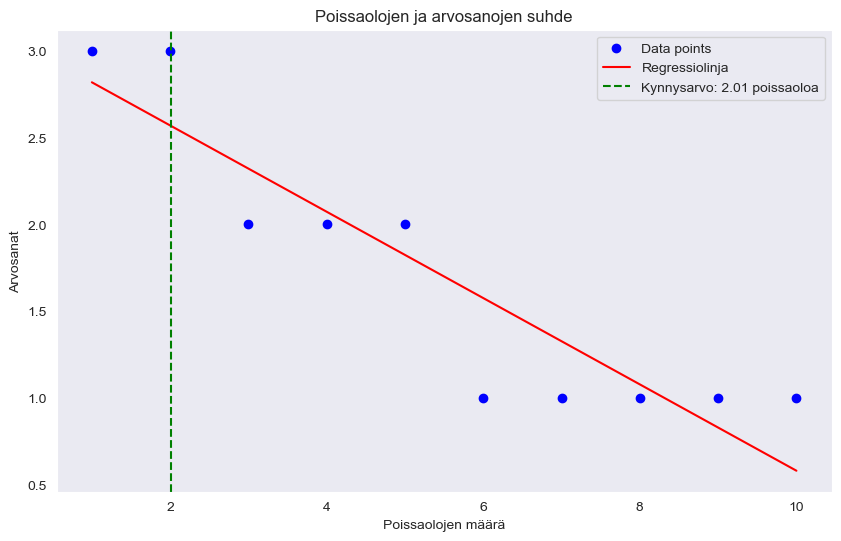

In [14]:
# Esimerkkidata luodaan DataFrame-muodossa (arvosanat 1–3)
data = pd.DataFrame({
    'total_absences': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grade': [3, 3, 2, 2, 2, 1, 1, 1, 1, 1]  # Esimerkkiarvosanat 1-3
})

# Poistetaan rivit, joilla on puuttuvia arvoja
data = data.dropna()

# Muutetaan arvosanat liukuluvuiksi (ei välttämätöntä, mutta hyvä käytäntö)
data['grade'] = data['grade'].astype(float)

# Luodaan hajontakaavio
plt.figure(figsize=(10, 6))  # Asetetaan kaavion koko
plt.scatter(data['total_absences'], data['grade'], label='Data points', color='blue')
plt.xlabel('Poissaolojen määrä')
plt.ylabel('Arvosanat')
plt.title('Poissaolojen ja arvosanojen suhde')
plt.grid()

# Sovitetaan lineaarinen regressiomalli
model = LinearRegression()
X = data['total_absences'].values.reshape(-1, 1)  # Muutetaan data mallin vaatimaa muotoon
y = data['grade']
model.fit(X, y)

# Tulostetaan mallin kerroin
print('Mallin kerroin:', model.coef_[0])

# Lasketaan kynnysarvo
threshold = -0.5 / model.coef_[0]
print('Poissaolojen kynnysarvo:', threshold)

# Piirretään regressiolinja
x_values = data['total_absences']
y_values = model.predict(x_values.values.reshape(-1, 1))
plt.plot(x_values, y_values, color='red', label='Regressiolinja')

# Merkitään kynnysarvo kaavioon
plt.axvline(x=threshold, color='green', linestyle='--', label=f'Kynnysarvo: {threshold:.2f} poissaoloa')
plt.legend()

# Näytetään kaavio
plt.show()

5. Voidaanko ennustaa opiskelijan menestys toisen jakson aikana ensimmäisen jakson perusteella?
- Kysymys: Voidaanko ensimmäisen jakson arvosanojen ja poissaolojen perusteella ennustaa toisen jakson suoriutumista?
- Analyysi: Käyttäkää ensimmäisen jakson tietoja mallina, ja testatkaa, kuinka hyvin ne ennustavat toisen jakson arvosanoja ja poissaoloja.

K-menas klusterointi
Miten eri opiskelijaryhmät eroavat toisistaan poissaolojen ja arvosanojen perusteella?

/var/folders/m9/ys404nm16gl3skcn4wym51kc0000gp/T/ipykernel_8101/1768046900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['average_mark'] = data_cleaned[[f'bellPeriod{period}_markbook_mark' for period in range(1, 7)]].mean(axis=1)
/var/folders/m9/ys404nm16gl3skcn4wym51kc0000gp/T/ipykernel_8101/1768046900.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['total_absences'] = data_cleaned['total_absences'].astype(int)
/var/folders/m9/ys404nm16gl3skcn4wym51kc0000gp/T/ipykernel

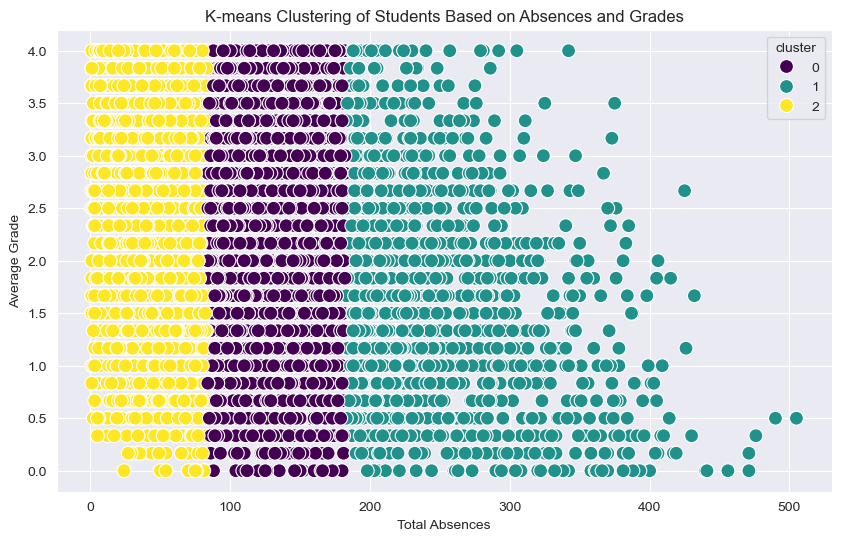

Cluster centers (Absences, Average Mark):
[[121.68137349   2.24151161]
 [243.79297821   1.59059726]
 [ 46.22521246   2.72306815]]


In [20]:
file_path = './archive/2023_GradesVsPeriodAttendance_01.csv'
data = pd.read_csv(file_path)

# Define a mapping for letter grades to numeric equivalents
grade_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}

# Convert the letter grades to numeric equivalents for all bell periods
for period in range(1, 7):
    column_name = f'bellPeriod{period}_markbook_mark'
    data[column_name] = data[column_name].map(grade_mapping)

# Drop rows with missing values in any of the grade columns (after mapping)
data_cleaned = data.dropna(subset=[f'bellPeriod{period}_markbook_mark' for period in range(1, 7)])

# Calculate the average mark across all periods
data_cleaned['average_mark'] = data_cleaned[[f'bellPeriod{period}_markbook_mark' for period in range(1, 7)]].mean(axis=1)

# Ensure 'total_absences' is an integer
data_cleaned['total_absences'] = data_cleaned['total_absences'].astype(int)

# Prepare the data for clustering (use total_absences and average_mark)
X_kmeans = data_cleaned[['total_absences', 'average_mark']]

# Apply K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data_cleaned['cluster'] = kmeans.fit_predict(X_kmeans)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_absences', y='average_mark', hue='cluster', data=data_cleaned, palette='viridis', s=100)
plt.title('K-means Clustering of Students Based on Absences and Grades')
plt.xlabel('Total Absences')
plt.ylabel('Average Grade')
plt.grid(True)
plt.show()

# Optional: Analyze the centers of each cluster
print("Cluster centers (Absences, Average Mark):")
print(kmeans.cluster_centers_)


Klusteri 0:

Poissaolojen keskiarvo: 121,68
Arvosanan keskiarvo: 2,24 (välillä "C" ja "B")
Tämä klusteri edustaa opiskelijoita, joilla on kohtalainen määrä poissaoloja (~121 päivää) ja keskimääräinen arvosana "C"
ja "B" välillä. Näillä opiskelijoilla on kohtalainen määrä poissaoloja, mutta he suoriutuvat silti keskimääräisesti. Tämä viittaa siihen, että poissaoloilla ei ole niin suurta vaikutusta heidän suoritukseensa, sillä he saavat silti "C"
ja "B" välisiä arvosanoja.


Klusteri 1:

Poissaolojen keskiarvo: 243,79
Arvosanan keskiarvo: 1,59 (välillä "D" ja "C")
Tämä klusteri edustaa opiskelijoita, joilla on erittäin paljon poissaoloja (~244 päivää) ja heikko suoritus (arvosanat väliltä "D" ja "C"). Näillä opiskelijoilla on todennäköisesti vaikeuksia koulussa, mikä saattaa liittyä heidän suureen poissaolomääräänsä.
Tällä ryhmällä on merkittävästi poissaoloja, ja heidän suorituksensa on sen mukaista, arvosanojen ollessa "D"
ja "C" välillä. Tämä viittaa vahvaan negatiiviseen yhteyteen poissaolojen ja heikompien suoritusten välillä.

Klusteri 2:

Poissaolojen keskiarvo: 46,23
Arvosanan keskiarvo: 2,72 (välillä "B" ja "A")
Tämä klusteri edustaa opiskelijoita, joilla on vähän poissaoloja (~46 päivää) ja keskimääräistä paremmat arvosanat (välillä "B" ja "A"). Nämä ovat hyvin menestyviä opiskelijoita, joilla on suhteellisen vähän poissaoloja. Vähäisten poissaolojen ja korkeiden arvosanojen yhdistelmä viittaa positiiviseen yhteyteen läsnäolon ja hyvän suorituksen välillä.

Jokainen piste kuvaa oppilasta ja pisteen sijainti perustuu oppilaan poissaolojen kokonaismäärään (X-akseli) ja keskimääräiseen arvosanaan (Y-akseli).
X-akseli = Mitä kauempana piste on oikealla, sitä enemmän oppilaalla on poissaoloja.
Y-akseli = Mitä korkeammalla piste on Y-akselilla, sitä parempi oppilaan keskimääräinen arvosana on.

Klusteri 0 (oppilaat, joilla on kohtalaisesti poissaoloja ja keskiverrot arvosanat) sijaitsee tyypillisesti molempien akseleiden keskialueella.
Klusteri 1 (oppilaat, joilla on paljon poissaoloja ja heikot arvosanat) sijaitsee X-akselilla oikealla (paljon poissaoloja) ja Y-akselilla alempana (heikot arvosanat).
Klusteri 2 (oppilaat, joilla on vähän poissaoloja ja hyvät arvosanat) sijaitsee vasemmalla X-akselilla (vähän poissaoloja) ja korkeammalla Y-akselilla (hyvät arvosanat).
